# 实战 Kaggle 比赛：图像分类 (CIFAR-10)¶

我们一直在使用深度学习框架的高级API直接获取张量格式的图像数据集。 
但是在实践中，图像数据集通常以图像文件的形式出现

CIFAR

In [29]:
import collections
import math
import os
import shutil #python用来下文件
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [30]:
# 这里使用了一个demo 是一个小的数据集（CIFAR-10 Tiny）

d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/' #将数据放在改文件路径

In [31]:
# 读放在'trainLabels.csv’下的label数据
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    # 将每行数据按逗号分割成文件名和标签
    tokens = [l.rstrip().split(',') for l in lines]
    # 创建并返回一个以文件名为键、标签为值的字典
    return dict(((name, label) for name, label in tokens))

# 获取标签字典
labels = read_csv_labels('..\\data\\kaggle_cifar10_tiny\\trainLabels.csv')
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


In [32]:
#labels就是图片的一些类型
labels

{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

In [33]:
# 将验证集从原始数据集中拆分出来 一个最简单的数据拆分函数

# 定义文件复制函数
def copyfile(filename, target_dir):
    """
    将文件复制到目标目录。
    
    参数:
    filename -- str, 要复制的文件路径
    target_dir -- str, 目标目录路径
    """
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

# 定义训练集和验证集拆分函数
def reorg_train_valid(data_dir, labels, valid_ratio):
    """
    将验证集从原始的训练集中拆分出来。
    
    参数:
    data_dir -- str, 数据目录路径
    labels -- dict, 文件名和标签的字典
    valid_ratio -- float, 验证集所占的比例
    
    返回:
    int -- 验证集中每个类别的样本数
    """
    # 获取训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 计算验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    
    # 遍历训练数据目录中的所有文件
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # 获取文件对应的标签
        label = labels[train_file.split('.')[0]]
        # 构建文件路径
        fname = os.path.join(data_dir, 'train', train_file)
        # 将文件复制到 'train_valid' 目录中
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        
        # 根据标签统计验证集中的样本数
        if label not in label_count or label_count[label] < n_valid_per_label:
            # 将文件复制到 'valid' 目录中
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 将文件复制到 'train' 目录中
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))

In [34]:
# 定义整理测试集函数
#@save
def reorg_test(data_dir):
    """
    在预测期间整理测试集，以方便读取。
    
    参数:
    data_dir -- str, 数据目录路径
    """
    # 遍历测试数据目录中的所有文件
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        # 将文件复制到 'train_valid_test/test/unknown' 目录中
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [35]:
# 使用一个函数来调用前面定义的函数read_csv_labels、reorg_train_valid和reorg_test。
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [36]:
batch_size = 32 if demo else 128
valid_ratio = 0.1 #90%用来训练模型 10%用来做验证
reorg_cifar10_data(data_dir, valid_ratio)

In [37]:
#进行图像增广 这是训练数据的图像增广
# 定义一个图像增广的变换序列 图片原来大小为32x32
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    
    # 以50%的概率水平翻转图像
    torchvision.transforms.RandomHorizontalFlip(),
    
    # 将图像数据转换为张量
    torchvision.transforms.ToTensor(),
    
    # 标准化图像的每个通道，使用CIFAR-10数据集的均值和标准差
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

In [38]:
#进行图像增广 这是测试数据的图像增广
transform_test = torchvision.transforms.Compose([
    # 将图像数据转换为张量
    torchvision.transforms.ToTensor(),
    
    # 标准化图像的每个通道，使用CIFAR-10数据集的均值和标准差
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

In [39]:
# 加载训练和训练验证数据集，应用数据增广变换
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [40]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [41]:
# 模型使用之前定义过的Resnet-18
def get_net():
    num_classes = 10 #表示网络的输出层有10个神经元，对应10个类别
    net = d2l.resnet18(num_classes, 3) #3表示输入时3通道 即图像RGB3通道
    return net


#损失函数的定义
loss = nn.CrossEntropyLoss(reduction="none")

In [42]:
net = get_net()
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [43]:
# 训练函数
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    
#     net: 待训练的神经网络模型。
#     train_iter: 训练数据集的迭代器。
#     valid_iter: 验证数据集的迭代器。
#     num_epochs: 训练的总轮数。
#     lr: 初始学习率。
#     wd: 权重衰减系数（L2正则化）。
#     devices: 用于训练的设备（例如GPU）。
#     lr_period: 学习率衰减的周期。
#     lr_decay: 学习率衰减的比例。
    
    # 使用SGD优化器，设置学习率、动量和权重衰减
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

    # 设置学习率调度器，每过lr_period个epoch，学习率按lr_decay比例衰减
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    
    # 获取训练集的batch数量，并初始化计时器
    num_batches, timer = len(train_iter), d2l.Timer()
    
    # 定义图例
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
        
    # 初始化绘图工具
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    
    # 使用DataParallel在多个GPU上并行运行模型
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    # 开始训练循环
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)  # 初始化累加器，用于记录训练损失和准确率
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            
            # 训练一个batch，并返回损失和准确率
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])  # 累加损失和准确率
            timer.stop()
            
            # 每训练完1/5个epoch或到达最后一个batch时，更新绘图
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None))
        
        # 每个epoch结束后，如果有验证集，计算验证准确率并更新绘图
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        
        # 更新学习率
        scheduler.step()
    
    # 输出最终的训练损失、训练准确率和验证准确率
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')
# 验证集上的准确率（validation accuracy）

train loss 0.584, train acc 0.787, valid acc 0.391
1041.6 examples/sec on [device(type='cuda', index=0)]


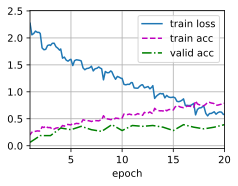

In [44]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.526, train acc 0.826
1292.1 examples/sec on [device(type='cuda', index=0)]


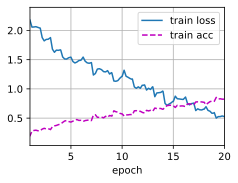

In [50]:
# 在 Kaggle 上对测试集进行分类并提交结果
# 在获得具有超参数的满意的模型后，
# 我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。
# 初始化网络模型和预测结果列表
net, preds = get_net(), []

# get_net()：初始化网络模型。
# preds：空列表，用于存储预测结果


# 使用训练+验证数据集来训练网络模型，验证集为空
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 对测试数据集进行预测

# 遍历测试数据集 test_iter。
# 将每个批次的输入数据 X 转移到第一个GPU设备上。
# 通过网络模型 net 进行前向传播，得到预测结果 y_hat。
# 使用 argmax(dim=1) 获取每个样本预测类别的索引。
# 将结果转换为CPU上的numpy数组，并添加到 preds 列表中



for X, _ in test_iter:
    # 将输入数据转移到第一个GPU设备上，然后进行前向传播，得到预测结果
    y_hat = net(X.to(devices[0]))
    # 获取每个样本预测类别的索引，转换为CPU上的numpy数组，并添加到预测结果列表中
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

# 创建一个从1到测试数据集样本数量的排序ID列表
# 对ID列表按字符串顺序进行排序。
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))

# 创建一个DataFrame来保存测试样本的ID和对应的预测标签
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# 将预测标签的索引转换为实际类别名称
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
# 将结果保存到一个CSV文件中，不包含行索引
df.to_csv('submission.csv', index=False)